In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
import time
import timeit

In [2]:
from datetime import datetime

In [3]:
df = pd.read_csv("VIX1.csv", 
                 na_values=['null'], 
                 index_col=['DATE'],
                 )
df

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
01/02/1990,17.24,17.24,17.24,17.24
01/03/1990,18.19,18.19,18.19,18.19
01/04/1990,19.22,19.22,19.22,19.22
01/05/1990,20.11,20.11,20.11,20.11
01/08/1990,20.26,20.26,20.26,20.26
...,...,...,...,...
11/29/2023,12.71,13.10,12.48,12.98
11/30/2023,13.07,13.39,12.82,12.92
12/01/2023,12.94,12.96,12.48,12.63


In [4]:
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (8556, 4)
Null Value Present:  False


<Axes: xlabel='DATE'>

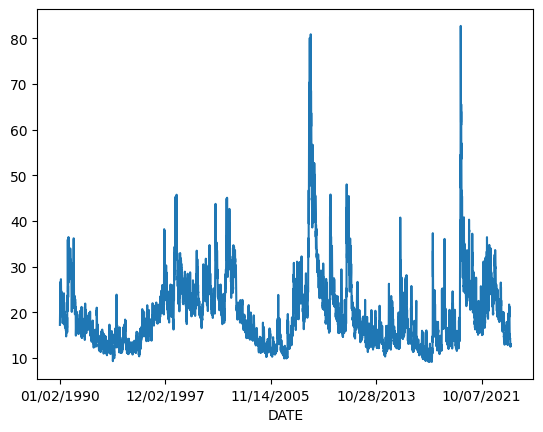

In [5]:
df['CLOSE'].plot()

In [6]:
output_var = pd.DataFrame(df['CLOSE'])
features = ['OPEN', 'HIGH', 'LOW',]

In [7]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,OPEN,HIGH,LOW
DATE,,,
01/02/1990,0.111699,0.098853,0.135202
01/03/1990,0.124593,0.110696,0.150000
01/04/1990,0.138572,0.123535,0.166044
01/05/1990,0.150651,0.134630,0.179907
01/08/1990,0.152687,0.136500,0.182243


In [8]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index) : 
                                                                              (len(train_index) + len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index) : 
                                                                               (len(train_index) + len(test_index))].values.ravel()
trainX = np.array(X_train)
testX = np.array(X_test)

X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [9]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

In [13]:
def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 1, 3, 1 
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)

In [15]:
transformer = build_transfromer(head_size=128, num_heads=3, ff_dim=2, 
                                num_trans_blocks=3, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10, 
                                )

In [16]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, 
                                              restore_best_weights=True)]

In [17]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist

In [18]:
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 3)]               0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 1, 3)                 6         ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 1, 3)                 5763      ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

 dropout_23 (Dropout)        (None, 1, 2)                 0         ['conv1d_20[0][0]']           
                                                                                                  
 conv1d_21 (Conv1D)          (None, 1, 3)                 9         ['dropout_23[0][0]']          
                                                                                                  
 tf.__operators__.add_21 (T  (None, 1, 3)                 0         ['conv1d_21[0][0]',           
 FOpLambda)                                                          'tf.__operators__.add_20[0][0
                                                                    ]']                           
                                                                                                  
 global_average_pooling1d_2  (None, 1)                    0         ['tf.__operators__.add_21[0][0
  (GlobalAveragePooling1D)                                          ]']                           
          

In [19]:
hist = fit_transformer(transformer)

Epoch 1/25


244/244 [==============================] - 5s 5ms/step - loss: 124.8066 - mae: 8.1689 - mape: 42.0894
Epoch 2/25
244/244 [==============================] - 1s 5ms/step - loss: 71.5049 - mae: 6.0397 - mape: 31.6945
Epoch 3/25
244/244 [==============================] - 1s 5ms/step - loss: 69.4006 - mae: 5.9808 - mape: 31.7424
Epoch 4/25
244/244 [==============================] - 1s 5ms/step - loss: 67.6564 - mae: 5.9090 - mape: 31.4607
Epoch 5/25
244/244 [==============================] - 1s 5ms/step - loss: 66.7172 - mae: 5.8697 - mape: 31.3039
Epoch 6/25
244/244 [==============================] - 1s 5ms/step - loss: 65.6321 - mae: 5.7931 - mape: 30.8940
Epoch 7/25
244/244 [==============================] - 1s 5ms/step - loss: 64.6700 - mae: 5.7656 - mape: 30.8245
Epoch 8/25
244/244 [==============================] - 1s 5ms/step - loss: 64.1016 - mae: 5.7417 - mape: 30.6514
Epoch 9/25
244/244 [==============================] - 1s 5ms/step - loss: 62.7077 - mae: 5.6667 - map

In [20]:
y_pred = hist.model.predict(X_test)

25/25 [==============================] - 0s 2ms/step


In [21]:
transformer_evals = Evaluate(y_test, y_pred)

In [22]:
print(transformer_evals.mape)
print(transformer_evals.var_ratio)

0.043682197490266125
0.3319462470939917


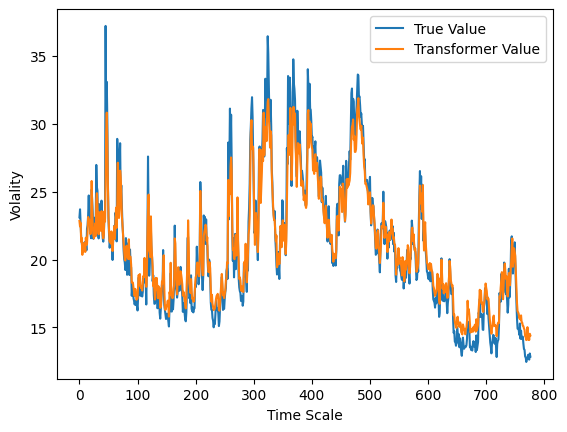

In [24]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='Transformer Value')
plt.xlabel('Time Scale')
plt.ylabel('Volality')
plt.legend()
plt.show()

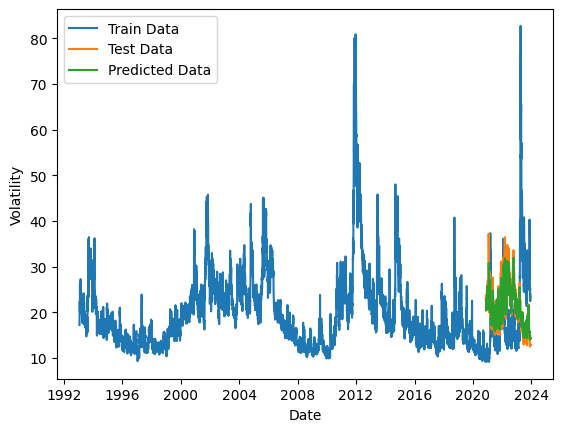

In [32]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# 绘制图表
plt.plot(df.index[-len(y_train):], y_train, label='Train Data')
plt.plot(df.index[-len(y_test):], y_test, label='Test Data')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# 设置日期间隔和格式
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(AutoDateFormatter(AutoDateLocator()))

plt.show()




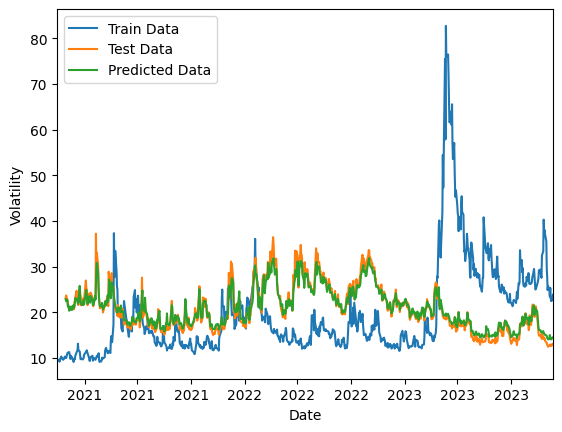

In [39]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# 绘制图表
plt.plot(df.index[-len(y_train):], y_train, label='Train Data')
plt.plot(df.index[-len(y_test):], y_test, label='Test Data')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# 设置日期间隔和格式
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(AutoDateFormatter(AutoDateLocator()))

# 指定要放大的时间范围（假设放大前两周的数据）
start_date = df.index[-len(y_pred) - 14]  # 替换为您数据集中的实际日期
end_date = df.index[-1]  # 替换为您数据集中的实际日期

plt.xlim(start_date, end_date)

plt.show()



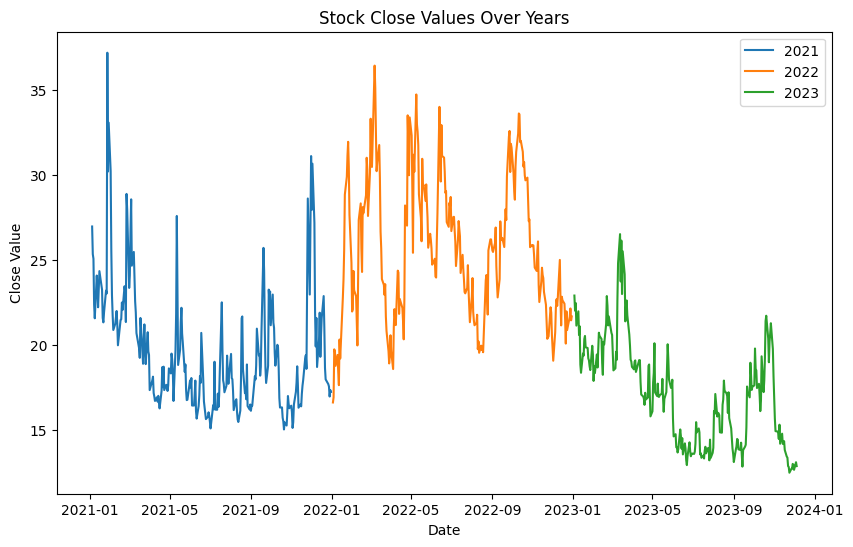

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
data = pd.read_csv('VIX1.csv')

# 将日期转换为日期时间格式
data['DATE'] = pd.to_datetime(data['DATE'])

# 提取年份和关闭价格
data['Year'] = data['DATE'].dt.year
close_prices = data['CLOSE']
years = data['Year']

# 分割数据为不同年份的子集
unique_years = years.unique()

plt.figure(figsize=(10, 6))

# 根据年份绘制图表，并设置标签
for year in unique_years:
    year_data = data[data['Year'] == year]
    if 2021 <= year <= 2023:  # 仅绘制 2020 到 2023 年的数据
        plt.plot(year_data['DATE'], year_data['CLOSE'], label=str(year))

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Stock Close Values Over Years')

plt.legend(loc='best')


plt.show()




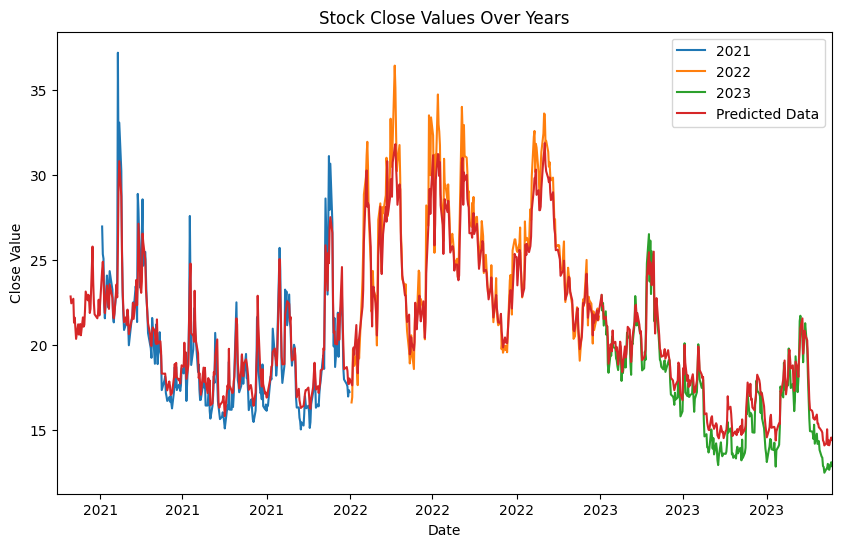

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
data = pd.read_csv('VIX1.csv')

# 将日期转换为日期时间格式
data['DATE'] = pd.to_datetime(data['DATE'])

# 提取年份和关闭价格
data['Year'] = data['DATE'].dt.year
close_prices = data['CLOSE']
years = data['Year']

# 分割数据为不同年份的子集
unique_years = years.unique()

plt.figure(figsize=(10, 6))

# 根据年份绘制图表，并设置标签
for year in unique_years:
    year_data = data[data['Year'] == year]
    if 2021 <= year <= 2023:  # 仅绘制 2020 到 2023 年的数据
        plt.plot(year_data['DATE'], year_data['CLOSE'], label=str(year))



plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Data')

# 设置日期间隔和格式
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(AutoDateFormatter(AutoDateLocator()))

# 指定要放大的时间范围（假设放大前两周的数据）
start_date = df.index[-len(y_pred) - 14]  # 替换为您数据集中的实际日期
end_date = df.index[-1]  # 替换为您数据集中的实际日期

plt.xlim(start_date, end_date)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Stock Close Values Over Years')

plt.legend(loc='best')


plt.show()

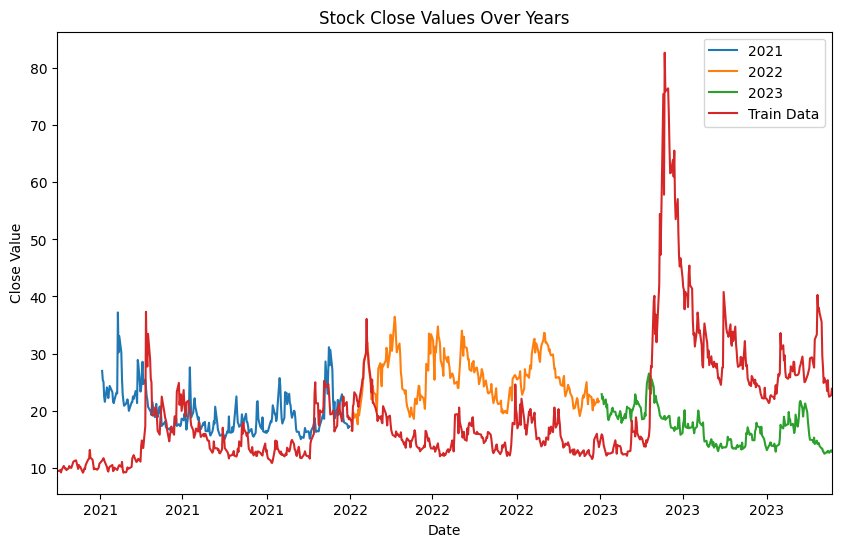

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
data = pd.read_csv('VIX1.csv')

# 将日期转换为日期时间格式
data['DATE'] = pd.to_datetime(data['DATE'])

# 提取年份和关闭价格
data['Year'] = data['DATE'].dt.year
close_prices = data['CLOSE']
years = data['Year']

# 分割数据为不同年份的子集
unique_years = years.unique()

plt.figure(figsize=(10, 6))

# 根据年份绘制图表，并设置标签
for year in unique_years:
    year_data = data[data['Year'] == year]
    if 2021 <= year <= 2023:  # 仅绘制 2020 到 2023 年的数据
        plt.plot(year_data['DATE'], year_data['CLOSE'], label=str(year))



plt.plot(df.index[-len(y_train):], y_train, label='Train Data')

# 设置日期间隔和格式
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(AutoDateFormatter(AutoDateLocator()))

# 指定要放大的时间范围（假设放大前两周的数据）
start_date = df.index[-len(y_pred) - 14]  # 替换为您数据集中的实际日期
end_date = df.index[-1]  # 替换为您数据集中的实际日期

plt.xlim(start_date, end_date)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Stock Close Values Over Years')

plt.legend(loc='best')


plt.show()